In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

In [8]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df.rename(columns={'Date(yyyy-mm-dd)': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop_duplicates()
    df = df[['Date', 'Mean']]
    
    Q1 = df['Mean'].quantile(0.25)
    Q3 = df['Mean'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['Mean'] >= Q1 - 1.5 * IQR) & (df['Mean'] <= Q3 + 1.5 * IQR)]
    
    return df

In [9]:
df = wrangle("OMNO2_Timeseries_Bishkek.csv")

KeyError: 'Median'

In [ ]:
df.info

In [10]:
df.head

<bound method NDFrame.head of            Date   Mean
0    2015-01-01  1.146
1    2015-01-02  1.154
2    2015-01-03  1.028
3    2015-01-04  1.083
4    2015-01-05  0.989
...         ...    ...
3282 2023-12-27  1.052
3283 2023-12-28  1.042
3284 2023-12-29  0.949
3285 2023-12-30  0.610
3286 2023-12-31  0.610

[3287 rows x 2 columns]>

In [11]:
df.isnull().sum()

Date    0
Mean    0
dtype: int64

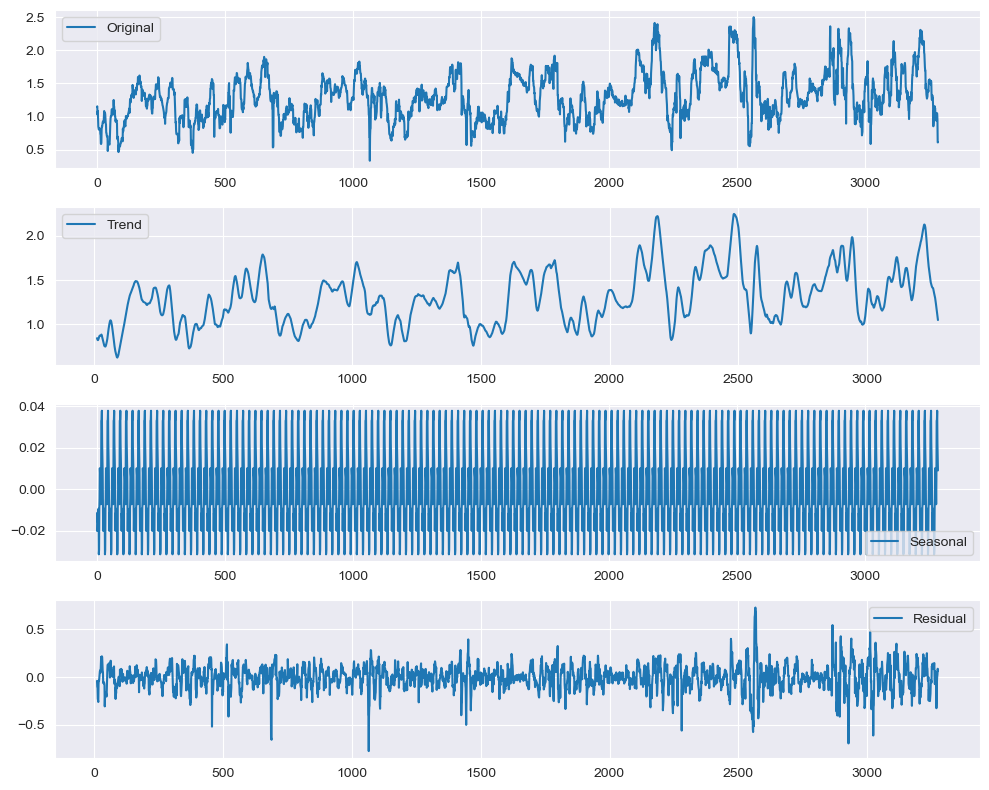

In [14]:
result = seasonal_decompose(df['Mean'], model='additive', period=24)
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(df['Mean'], label='Original')
axes[0].legend()
axes[1].plot(result.trend, label='Trend')
axes[1].legend()
axes[2].plot(result.seasonal, label='Seasonal')
axes[2].legend()
axes[3].plot(result.resid, label='Residual')
axes[3].legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


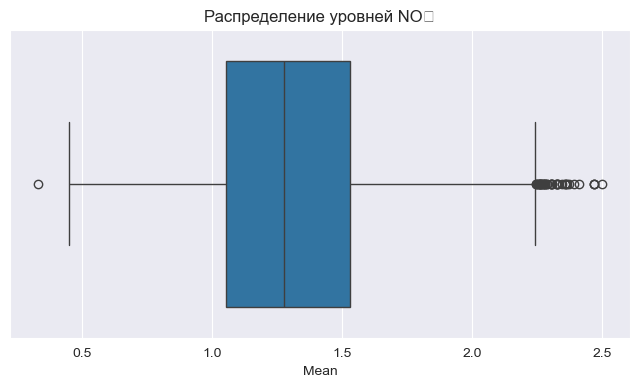

In [19]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Mean'])
plt.title("Распределение уровней NO₂")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


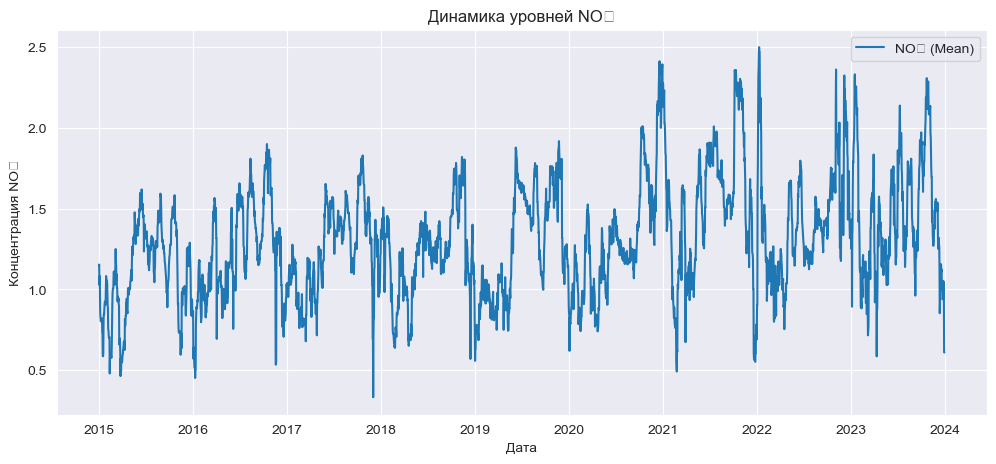

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Mean'], label='NO₂ (Mean)')
plt.xlabel("Дата")
plt.ylabel("Концентрация NO₂")
plt.title("Динамика уровней NO₂")
plt.legend()
plt.show()

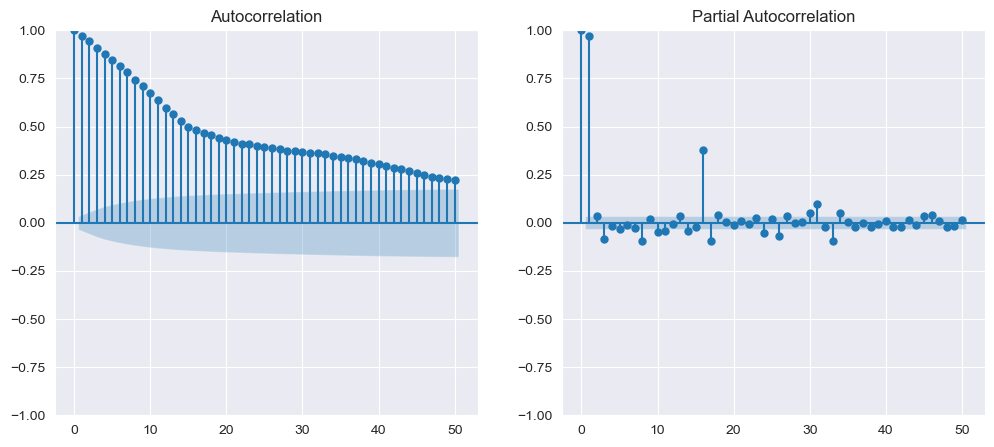

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Mean'], ax=axes[0], lags=50)
plot_pacf(df['Mean'], ax=axes[1], lags=50)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


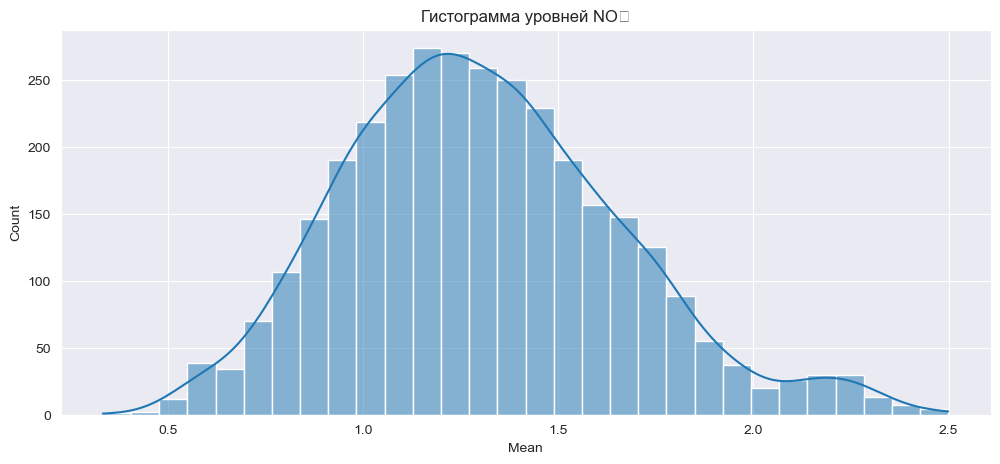

In [29]:
plt.figure(figsize=(12, 5))
sns.histplot(df['Mean'], bins=30, kde=True)
plt.title("Гистограмма уровней NO₂")
plt.show()

In [34]:
baseline_pred = df['Mean'].shift(1).dropna()
baseline_mae = mean_absolute_error(df['Mean'][1:], baseline_pred)
print(f"Baseline MAE: {baseline_mae}")

Baseline MAE: 0.054256238587948875


In [61]:
p = 450
test_size = int(len(df) * 0.2)
train, test = df['Mean'][:-test_size], df['Mean'][-test_size:]

In [62]:
ar_model = AutoReg(train, lags=p).fit()
predictions = ar_model.predict(start=len(train), end=len(df)-1, dynamic=False)

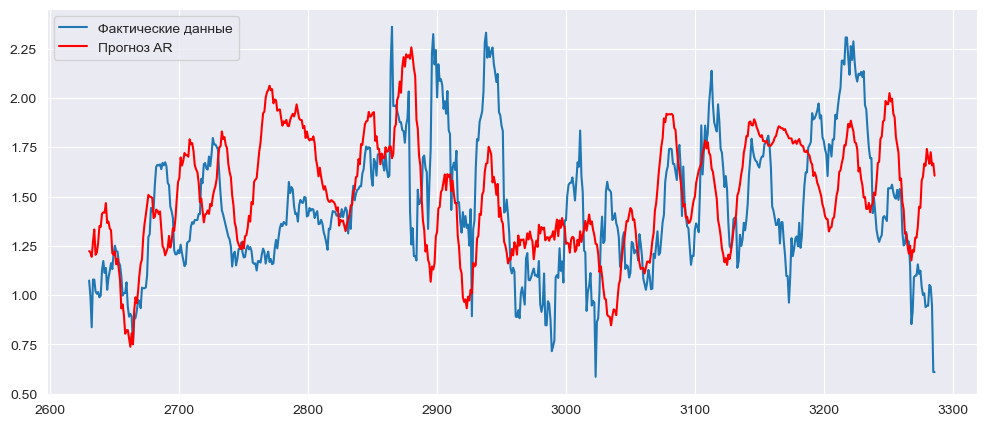

In [63]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label="Фактические данные")
plt.plot(test.index, predictions, label="Прогноз AR", color='red')
plt.legend()
plt.show()

In [64]:
print(f"MAE до WFV: {mean_absolute_error(test, predictions)}")
print(f"RMSE до WFV: {np.sqrt(mean_squared_error(test, predictions))}")

MAE до WFV: 0.3075950654470439
RMSE до WFV: 0.3715556900341602


In [79]:
wfv_predictions = []
wfv_test = []
window_size = 50
for i in range(window_size, len(test)):
    wfv_train = df['Mean'][:train.index[-1] + i]
    model = AutoReg(wfv_train, lags=p).fit()
    pred = model.predict(start=len(wfv_train), end=len(wfv_train))
    wfv_predictions.append(pred.iloc[0])
    wfv_test.append(test.iloc[i])

In [80]:
print(f"MAE после WFV: {mean_absolute_error(wfv_test, wfv_predictions)}")
print(f"RMSE после WFV: {np.sqrt(mean_squared_error(wfv_test, wfv_predictions))}")

MAE после WFV: 0.10495184714950012
RMSE после WFV: 0.14553103068533152


In [81]:
arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_pred = arima_model.predict(start=len(train), end=len(df)-1, dynamic=False)

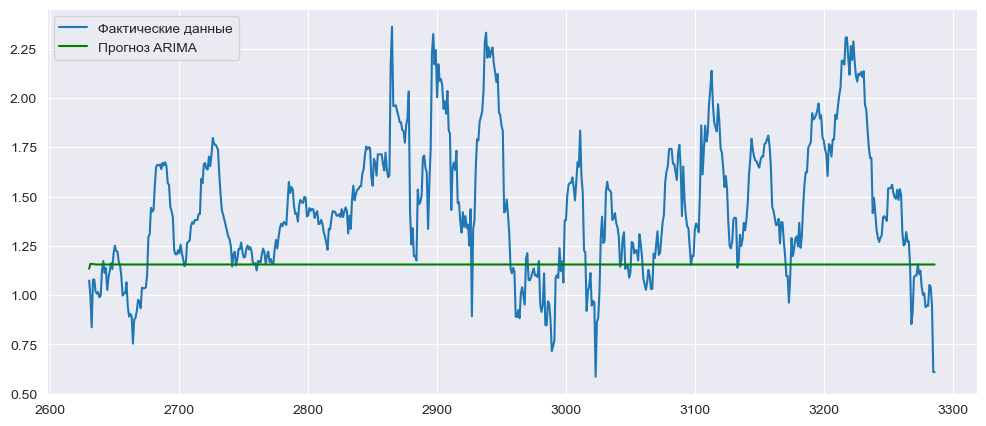

In [82]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label="Фактические данные")
plt.plot(test.index, arima_pred, label="Прогноз ARIMA", color='green')
plt.legend()
plt.show()

13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing


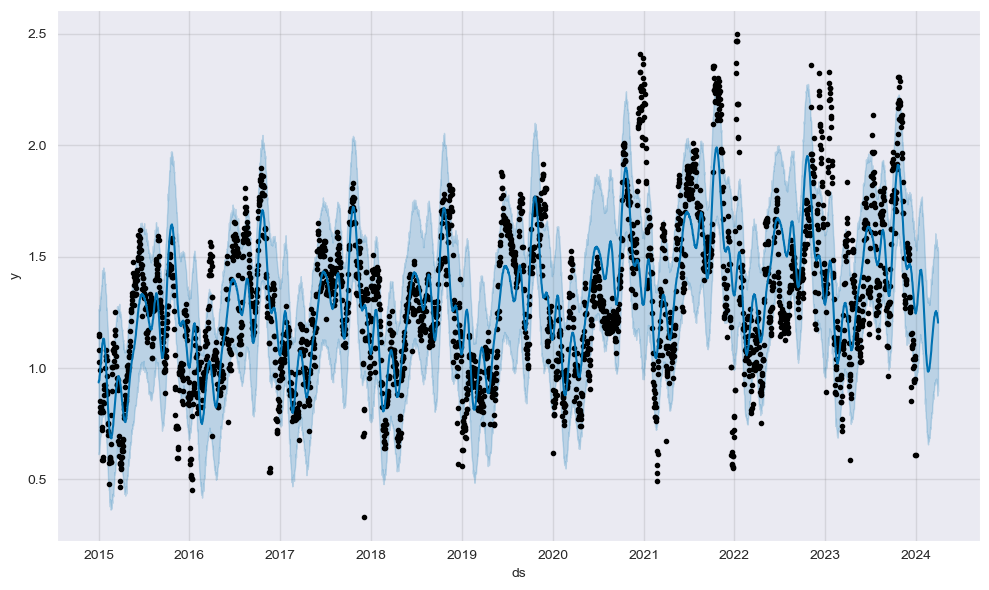

In [69]:
prophet_df = df.rename(columns={'Date': 'ds', 'Mean': 'y'})
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
model.plot(forecast)
plt.show()